In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:



import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf 


print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from attention import Attention_Block
# from attention import attention_block
from tensorflow.keras.layers import Attention
from step_attention import AttentionAugmentation2D, _normalize_depth_vars
# from keras.models import load_model

# In[2]:


# from google.colab import drive
# drive.mount('/content/drive')



# In[3]:


from loss import discounted_l1, max_displacement_error,v3_displacement_error
import math
import pickle5 as pickle
import matplotlib.pyplot as plt
from numpy import array
# import horovod.tensorflow.keras as hvd

2.2.0


In [2]:

# hvd.init()

# In[4]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"


gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)


if gpus:
    
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except:
        print('checking gpu error')
print('checking GPUs')


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=tf.compat.v1.ConfigProto()
# config.gpu_options.visible_device_list= '0,1'
config.gpu_options.allow_growth=True

config.log_device_placement=True
# config.visible_device_list =2
sess=tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)


# In[5]:


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from load_data import load_data
import os

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
checking gpu error
checking GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1



In [3]:

from pathlib import Path
home = str(Path.home())


train_X_route = '/home/lab1/repo/lyft/newarray/training_features_cyclist.npy'
# test_route = home+'/repo/data/X_to_val.npy'

train_y_route = '/home/lab1/repo/lyft/newarray/training_labels_cyclist.npy'
# test_y_route = home+'/repo/data/y_to_val.npy'

X_train = np.load(train_X_route,allow_pickle=True).astype(float)
y_train = np.load(train_y_route,allow_pickle=True).astype(float)
y_train=np.array([x[0] for x in y_train])

print(X_train.shape,y_train.shape)

X_train, X_test, y_train, y_test= \
train_test_split(X_train, y_train,test_size=0.1, random_state=1)

X_val, X_test, y_val, y_test= \
train_test_split(X_test, y_test,test_size=0.5, random_state=1)

print(X_val.shape, y_val.shape)

(35347, 10, 2) (35347, 2)
(1767, 10, 2) (1767, 2)


In [4]:
# print(X_position.shape, y.shape, X.shape)
print(X_train.shape, y_train.shape)
print(y_train[0])
# X_train=X_train[:300000]
# y_train=y_train[:300000]

(31812, 10, 2) (31812, 2)
[-0.03497314 -0.02423096]


In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=1)

In [6]:
# X_val=np.load("c_xval.npy")
# y_val=np.load('c_yval.npy')
# X_train=np.load("c_xtrain.npy")
# y_train=np.load("c_ytrain.npy")
# X_test=np.load("c_xtest.npy")
# y_test=np.load("c_ytest.npy")
from pathlib import Path
home = str(Path.home())

In [7]:

# In[9]:


filters=20
kernel_size = (3,3)
strides = (1,1)
depth_k =0.2
depth_v =0.2

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
print("before normalized k, v",depth_k,depth_k,strides)
depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)
print("after normalized k, v",depth_k,depth_k,strides)


# In[10]:
time_step=10
tf.compat.v1.disable_eager_execution()

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, kernel_regularizer='l1', input_shape=(time_step,2)))
rnn.add(LSTM(256, return_sequences=True, kernel_regularizer='l1',input_shape=(time_step,128)))
rnn.add(Reshape((time_step,16,16,1)))
rnn.summary()



cnn = Sequential()

cnn.add(Conv2D(1024, (4, 4),input_shape=(16, 16, 1)))
cnn.add(Conv2D(512, (2, 2)))
cnn.add(Conv2D(256, (4, 4)))
cnn.add(Conv2D(128, (2, 2)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(64, (2, 2)))
cnn.add(Conv2D(32, (2, 2)))
cnn.add(Conv2D(16, (2, 2)))

#attention block below
cnn.add(Conv2D(2 * depth_k + depth_k, (1, 1), strides))
cnn.add(AttentionAugmentation2D(depth_k, depth_v, num_heads=4, relative=True))

# cnn.add(Dropout(0.5))
cnn.add(Flatten())

 
cnn.add(Dense(128))
cnn.add(Dense(32))

cnn.summary() 



rnn2=Sequential()
rnn2.add(GRU(256, input_shape=(time_step,32)))


dense = Sequential()
dense.add(Dense(128))
dense.add(Dense(64))
dense.add(Dense(2)) # Model output

main_input = Input(shape=(time_step,2)) 
model = rnn(main_input)
model = TimeDistributed(cnn)(model) 
 # combine timedistributed cnn, attention, and fully connected network with rnn
model = rnn2(model)
model = dense(model) # add dense
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()


before normalized k, v 0.2 0.2 (1, 1)
after normalized k, v 4 4 (1, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
reshape (Reshape)            (None, 10, 16, 16, 1)     0         
Total params: 461,312
Trainable params: 461,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 1024)      17408     
________

In [13]:


n_batch = 32

n_epoch  = 150


checkpoint_path =home+ "/repo/models/lyft_cyctransferped_005_{epoch}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


 #(None, n_steps, n_features)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5, nesterov=True)
rmsprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)



ftrl = tf.keras.optimizers.Ftrl(learning_rate=0.01)


mtrc = [tf.keras.metrics.MeanAbsoluteError()]
# [tf.keras.metrics.CosineSimilarity(axis=1)]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=10000,
    decay_rate=0.95)

adagrad = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)

# to use customized loss, choose from  discounted_l1 or max_displacement_error function as loss parameter 
final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
final_model.load_weights('/home/lab1/repo/models/lyft_pednew_150.h5')

history=final_model.fit(X_train, 
                        y_train, epochs=n_epoch, 
                        batch_size=n_batch, 
                        verbose=2, 
                        validation_data=(X_val, y_val),
                        callbacks=[cp_callback])





Train on 31812 samples, validate on 1767 samples
Epoch 1/150

Epoch 00001: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_1.h5
31812/31812 - 131s - loss: 0.3460 - mean_absolute_error: 0.1742 - val_loss: 0.3577 - val_mean_absolute_error: 0.1566
Epoch 2/150

Epoch 00002: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_2.h5
31812/31812 - 132s - loss: 0.3576 - mean_absolute_error: 0.1634 - val_loss: 0.7926 - val_mean_absolute_error: 0.4565
Epoch 3/150

Epoch 00003: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_3.h5
31812/31812 - 132s - loss: 0.3687 - mean_absolute_error: 0.1574 - val_loss: 0.5553 - val_mean_absolute_error: 0.2405
Epoch 4/150

Epoch 00004: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_4.h5
31812/31812 - 134s - loss: 0.3773 - mean_absolute_error: 0.1524 - val_loss: 0.3499 - val_mean_absolute_error: 0.1414
Epoch 5/150

Epoch 00005: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_5.h5
31812/31812 -

Epoch 40/150

Epoch 00040: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_40.h5
31812/31812 - 132s - loss: 0.4379 - mean_absolute_error: 0.1225 - val_loss: 0.5971 - val_mean_absolute_error: 0.2475
Epoch 41/150

Epoch 00041: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_41.h5
31812/31812 - 132s - loss: 0.4353 - mean_absolute_error: 0.1209 - val_loss: 0.7290 - val_mean_absolute_error: 0.3102
Epoch 42/150

Epoch 00042: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_42.h5
31812/31812 - 133s - loss: 0.4338 - mean_absolute_error: 0.1200 - val_loss: 0.4298 - val_mean_absolute_error: 0.1363
Epoch 43/150

Epoch 00043: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_43.h5
31812/31812 - 133s - loss: 0.4344 - mean_absolute_error: 0.1208 - val_loss: 0.5693 - val_mean_absolute_error: 0.1907
Epoch 44/150

Epoch 00044: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_44.h5
31812/31812 - 133s - loss: 0.4313 - mean_absolute_er

Epoch 79/150

Epoch 00079: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_79.h5
31812/31812 - 132s - loss: 0.3831 - mean_absolute_error: 0.1055 - val_loss: 0.4245 - val_mean_absolute_error: 0.1136
Epoch 80/150

Epoch 00080: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_80.h5
31812/31812 - 132s - loss: 0.3796 - mean_absolute_error: 0.1038 - val_loss: 0.3579 - val_mean_absolute_error: 0.1058
Epoch 81/150

Epoch 00081: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_81.h5
31812/31812 - 133s - loss: 0.3802 - mean_absolute_error: 0.1048 - val_loss: 0.5494 - val_mean_absolute_error: 0.1858
Epoch 82/150

Epoch 00082: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_82.h5
31812/31812 - 133s - loss: 0.3769 - mean_absolute_error: 0.1033 - val_loss: 0.4220 - val_mean_absolute_error: 0.1439
Epoch 83/150

Epoch 00083: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_83.h5
31812/31812 - 132s - loss: 0.3753 - mean_absolute_er

Epoch 118/150

Epoch 00118: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_118.h5
31812/31812 - 133s - loss: 0.3281 - mean_absolute_error: 0.0929 - val_loss: 0.3990 - val_mean_absolute_error: 0.1580
Epoch 119/150

Epoch 00119: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_119.h5
31812/31812 - 133s - loss: 0.3283 - mean_absolute_error: 0.0936 - val_loss: 0.4571 - val_mean_absolute_error: 0.1602
Epoch 120/150

Epoch 00120: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_120.h5
31812/31812 - 133s - loss: 0.3288 - mean_absolute_error: 0.0943 - val_loss: 0.4008 - val_mean_absolute_error: 0.1601
Epoch 121/150

Epoch 00121: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_121.h5
31812/31812 - 134s - loss: 0.3256 - mean_absolute_error: 0.0927 - val_loss: 0.5505 - val_mean_absolute_error: 0.2195
Epoch 122/150

Epoch 00122: saving model to /home/lab1/repo/models/lyft_cyctransferped_005_122.h5
31812/31812 - 133s - loss: 0.3239 - mean_a

In [14]:
print("Evaluate on test data")
results = final_model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


_history_path = home+ '/repo/models/cyctransferped005_history.sav'
pickle.dump(history.history, open(_history_path, 'wb'))

_weights_path =  home+ '/repo/models/cyctransferped005_weights.h5'
final_model.save_weights(_weights_path)


Evaluate on test data
test loss, test acc: [0.29799364824100855, 0.10199447]


0.47084398524769894

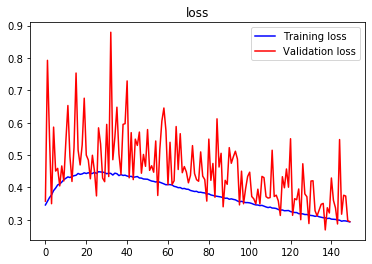

In [15]:
history.history.keys()
ax1,=plt.plot( history.history['loss'], c='b', label='Training loss')
ax2,=plt.plot( history.history['val_loss'], c='r', label='Validation loss')

plt.legend(handles=[ax1,ax2])
plt.title('loss')
plt.show()

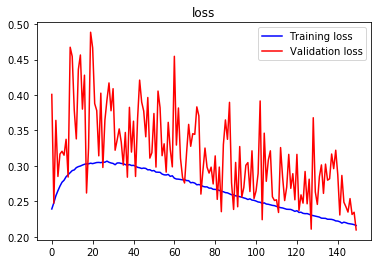

In [11]:
history.history.keys()
ax1,=plt.plot( history.history['loss'], c='b', label='Training loss')
ax2,=plt.plot( history.history['val_loss'], c='r', label='Validation loss')

plt.legend(handles=[ax1,ax2])
plt.title('loss')
plt.show()

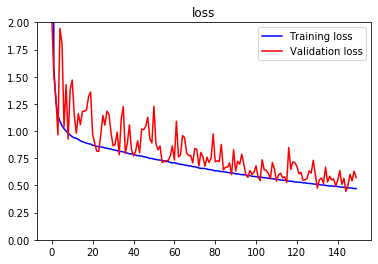

In [19]:
_history_path = home+ '/repo/models/cycnew_history.sav'
history= pickle.load(open(_history_path, 'rb'))

history.keys()
ax1,=plt.plot( history['loss'], c='b', label='Training loss')
ax2,=plt.plot( history['val_loss'], c='r', label='Validation loss')

plt.legend(handles=[ax1,ax2])
plt.title('loss')
plt.ylim(0,2)
plt.show()

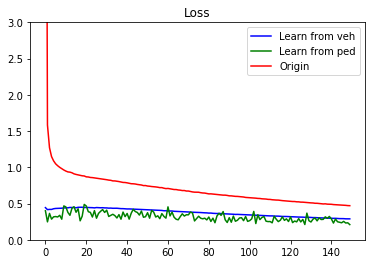

In [24]:
#compare 
_history_path = home+ '/repo/models/cyctransferveh_history.sav'
history_veh= pickle.load(open(_history_path, 'rb'))

_history_path = home+ '/repo/models/cyctransferped_history.sav'
history_ped= pickle.load(open(_history_path, 'rb'))

_history_path = home+ '/repo/models/cycnew_history.sav'
history_origin= pickle.load(open(_history_path, 'rb'))


ax1,=plt.plot( history_veh['loss'], c='b', label='Learn from veh')
ax2,=plt.plot( history_ped['val_loss'], c='g', label='Learn from ped')
ax3,=plt.plot( history_origin['loss'], c='r', label='Origin')

plt.legend(handles=[ax1,ax2, ax3])
plt.title('Loss')
plt.ylim(0,3)
plt.show()
